## Importación de librerías

In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import re
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
import nltk
from nltk.corpus import words

In [2]:
nltk.download('punkt')
nltk.download('words')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/edgarchambilla/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/edgarchambilla/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

## Procesamiento de datos

In [4]:
# Cargar el archivo CSV
# --------------------------------
datos_train = pd.read_csv('data/train.csv')
datos_train['label'] = datos_train['label'].replace({'pos': 1, 'neg': -1})
#---------------------------------
datos_test = pd.read_csv('data/test.csv')


Para el procesamiento de los datos vamos a incluir a las palabras dentro del diccionario en ingles. 

In [4]:
# Preprocesamiento
english_words = set(words.words())


Para este procesamiento estaremos usando el indice del TFID el cual nos brindara una matriz caracteristica de las palabras que se encuentran en el texto. Dando relevancia a las palabras mas significativas.

In [5]:
class StemmedTfidfVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedTfidfVectorizer, self).build_analyzer()
        stemmer = PorterStemmer()
        return lambda doc: (stemmer.stem(w) for w in analyzer(doc) 
                            if not re.fullmatch(r'\d+', w) 
                            and w in english_words
                            )

#### Generacion de un nuevo dataset con las siguientes columnas de nuestra matrix caracteristica:

In [6]:
# Crear el vectorizador
vectorizer = StemmedTfidfVectorizer(stop_words='english',sublinear_tf=True)

# Datos de entrenamiento
tfidf_matrix_original = vectorizer.fit_transform(datos_train["message"].values)
tfidf_matrix_original = tfidf_matrix_original.astype('float32')
tfidf_df_original = pd.DataFrame(tfidf_matrix_original.toarray(), columns=vectorizer.get_feature_names_out())

# Datos de para el test
tfidf_matrix_test = vectorizer.transform(datos_test["message"].values)
tfidf_matrix_test = tfidf_matrix_test.astype('float32')
tfidf_df_nuevos = pd.DataFrame(tfidf_matrix_test.toarray(), columns=vectorizer.get_feature_names_out())


In [7]:
# Insertar la columna de etiquetas como la primera columna
tfidf_df_original.insert(0, 'label___', datos_train['label'].values)

In [8]:
tfidf_df_original.shape

(25000, 19213)

In [9]:
tfidf_df_nuevos.shape

(25000, 19212)

#### Generación de un nuevo dataset con las siguientes columnas de nuestra matrix caracteristica:

In [5]:
# !!!!! DESCOMENTAR PARA GUARDAR LOS DATOS

# Print the shape of the matrix
# print("Shape of the TF-IDF matrix:", tfidf_matrix.shape)

# tfidf_df.to_csv('tfidf_values_10values.csv', index=False)


## Data analysis

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
import matplotlib.pyplot as plt

In [ ]:
# !!!!!! DESCOMENTAR PARA CARGAR LOS DATOS EN CASO SE QUIERA USAR EL DATASET YA PROCESADO

# # importing or loading the dataset
# dataset = pd.read_csv('tfidf_values_10values.csv')

# # distributing the dataset into two components X and Y
# X = dataset.iloc[:, 1:].values
# Y = dataset.iloc[:, 0].values
# print(X.shape, Y.shape)

(5087, 26082) (5087,)


In [11]:
# Dividiendo las variables X e Y en el conjunto de entrenamiento
X_train = tfidf_df_original.iloc[:, 1:].values
y_train = tfidf_df_original.iloc[:, 0].values
print(X_train.shape, y_train.shape)

(25000, 19212) (25000,)


In [12]:
# Testing set
X_test = tfidf_df_nuevos.values
print(X_test.shape)

(25000, 19212)


In [11]:
# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.1, random_state = 42)
# print(X_train.shape, X_test.shape)

(22500, 19212) (2500, 19212)


Aplicamos el Scaler para normalizar los datos y poder aplicar el modelo de regresión logística.

In [13]:
sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

Aplicamos PCA a nuestro dataset para reducir la dimensionalidad de los datos.

El valor del PCA fue calculado en 0.95. Este valor fue proporcionado por la grafica que se presenta mas adelante.

In [14]:
pca = PCA(n_components = 11924,)
X_train = pca.fit_transform(X_train)

In [6]:
# !!! DESCOMENTAR PARA GUARDAR EL MODELO DE PCA
# import joblib
# joblib.dump(pca, 'pca_configuration.pkl')

# !!! DESCOMENTAR PARA CARGAR EL MODELO DE PCA
# pca = joblib.load('pca_configuration.pkl')

In [16]:
X_test = pca.transform(X_test)

In [17]:
X_train.shape, X_test.shape

((25000, 11924), (25000, 11924))

In [22]:
# df_Xtrain = pd.DataFrame(X_train)
# df_Xtrain.to_csv('Xtrain.csv', index=False)

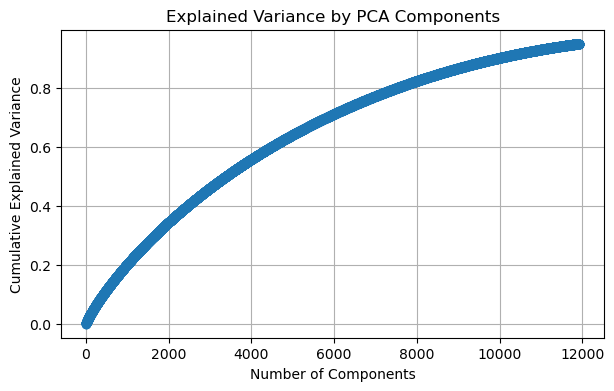

Number of components that explain at least 95% of the variance: 1


In [18]:
# Proporción de varianza explicada
explained_variance = pca.explained_variance_ratio_

# Varianza explicada acumulada
cumulative_explained_variance = explained_variance.cumsum()

# Graficar la varianza explicada acumulada
plt.figure(figsize=(7, 4))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.xlabel('Número de Componentes')
plt.ylabel('Varianza Explicada Acumulada')
plt.title('Varianza Explicada por Componentes de PCA')
plt.grid(True)
plt.show()

# Imprimir el número de componentes que explican al menos el 95% de la varianza
num_components_95 = (cumulative_explained_variance >= 0.95).argmax() + 1
print(f'Número de componentes que explican al menos el 95% de la varianza: {num_components_95}')


### Regresion logistica

In [7]:
class RegresionLogistica:
    def _init_(self, learning_rate=0.01, epochs=1000):
        self.learning_rate = learning_rate
        self.epochs = epochs

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        self.m, self.n = X.shape
        self.theta = np.zeros(self.n)
        self.bias = 0

        for epoch in range(self.epochs):
            linear_model = np.dot(X, self.theta) + self.bias
            y_pred = self.sigmoid(linear_model)

            d_theta = (1 / self.m) * np.dot(X.T, (y_pred - y))
            d_bias = (1 / self.m) * np.sum(y_pred - y)

            self.theta -= self.learning_rate * d_theta
            self.bias -= self.learning_rate * d_bias

    def predict(self, X):
        linear_model = np.dot(X, self.theta) + self.bias
        y_pred = self.sigmoid(linear_model)
        return [1 if i > 0.5 else 0 for i in y_pred]

In [ ]:
classifier = RegresionLogistica()
classifier.fit(X_train, y_train)

In [ ]:
y_pred = classifier.predict(X_test)

In [ ]:
# Mapear los valores de y_pred
y_pred_mapped = ["pos" if y == 1 else "neg" for y in y_pred]

# Crear la lista de IDs
ids = list(range(0, len(y_pred)))

# Crear un nuevo DataFrame con los valores mapeados y los IDs
df = pd.DataFrame({
    'ids': ids,
    'label': y_pred_mapped
})

# Exportar el DataFrame a un archivo CSV
df.to_csv('predictions_logistic_6.csv', index=False)


In [21]:
from sklearn.metrics import confusion_matrix, f1_score

cm = confusion_matrix(y_test, y_pred)

f1 = f1_score(y_test, y_pred, average='weighted')
print(f'F1 Score (weighted): {f1}')

f1_per_class = f1_score(y_test, y_pred, average=None)
print(f'F1 Score per class: {f1_per_class}')

F1 Score (weighted): 0.8072045695076198
F1 Score per class: [0.80131904 0.81274281]


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


# RED NEURONAL

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim

In [30]:
device = torch.device('cpu')
print(f'Using device: {device}')

Using device: cpu


In [31]:
y_train = np.where(y_train == -1, 0, y_train)

In [38]:
# Convertir a tensores de PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
# y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
# y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1).to(device)

In [39]:
class model5(nn.Module):
    def __init__(self, num_variables):
        super().__init__()
        self.hidden1 = nn.Linear(num_variables, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.act1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)
        
        self.hidden2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.act2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.5)
        
        self.hidden3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.act3 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.5)
        
        self.output = nn.Linear(64, 1)
        self.act_output = nn.Sigmoid()

    def forward(self, x):
        x = self.act1(self.bn1(self.hidden1(x)))
        x = self.dropout1(x)
        x = self.act2(self.bn2(self.hidden2(x)))
        x = self.dropout2(x)
        x = self.act3(self.bn3(self.hidden3(x)))
        x = self.dropout3(x)
        x = self.act_output(self.output(x))
        return x

In [40]:
n_variables = X_train.shape[1]
model = model5(num_variables=n_variables).to(device)
print(model)

loss_fn = nn.BCELoss()  # binary cross entropy
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

n_epochs = 100
batch_size = 16

model5(
  (hidden1): Linear(in_features=14000, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU()
  (dropout1): Dropout(p=0.5, inplace=False)
  (hidden2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act2): ReLU()
  (dropout2): Dropout(p=0.5, inplace=False)
  (hidden3): Linear(in_features=128, out_features=64, bias=True)
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act3): ReLU()
  (dropout3): Dropout(p=0.5, inplace=False)
  (output): Linear(in_features=64, out_features=1, bias=True)
  (act_output): Sigmoid()
)


In [41]:
for epoch in range(n_epochs):
    model.train()
    for i in range(0, len(X_train_tensor), batch_size):
        Xbatch = X_train_tensor[i:i+batch_size]
        y_pred = model(Xbatch)
        ybatch = y_train_tensor[i:i+batch_size]
        loss = loss_fn(y_pred, ybatch.unsqueeze(1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    scheduler.step(loss)
    
    if epoch % 10 == 0:
        print(f'Finished epoch {epoch}, latest loss {loss.item()}')


Finished epoch 0, latest loss 1.021173119544983
Finished epoch 10, latest loss 1.7595778703689575
Finished epoch 20, latest loss 0.5837146043777466
Finished epoch 30, latest loss 0.5944615006446838
Finished epoch 40, latest loss 0.005010257940739393
Finished epoch 50, latest loss 0.020400457084178925
Finished epoch 60, latest loss 0.002198053291067481
Finished epoch 70, latest loss 0.023332126438617706
Finished epoch 80, latest loss 0.08503291755914688
Finished epoch 90, latest loss 0.007855339907109737


In [ ]:
model.eval()
with torch.no_grad():
    # y_pred_train = model(X_train_tensor)
    y_pred_test = model(X_test_tensor)

In [49]:
y_predictions = (model(X_test_tensor) > 0.1).int()

In [50]:
# Extraer los valores de los tensores y convertirlos en una lista
predictions_list = [int(i.item()) for i in y_predictions]
# predictions_list = ["pos" if y == 1 else "neg" for y in y_pred]
Y_NN = ["pos" if y == 1 else "neg" for y in predictions_list]

ids_NN = list(range(0, len(Y_NN)))
# Crear un DataFrame con los valores

df = pd.DataFrame({
    'ids': ids_NN,
    'label': Y_NN
})
# Guardar el DataFrame en un archivo CSV
df.to_csv('predictions_NN.csv', index=False)

# Mostrar el DataFrame
print(df)

         ids label
0          0   neg
1          1   pos
2          2   neg
3          3   neg
4          4   neg
...      ...   ...
24995  24995   pos
24996  24996   pos
24997  24997   neg
24998  24998   pos
24999  24999   neg

[25000 rows x 2 columns]
